# NEACRP C1 Rod Ejection Accident

**Inputs**

- `rod_worth`: Reactivity worth of the ejected rod
- `beta`: Delayed neutron fraction 
- `h_gap`: Gap conductance ($\frac{W}{m^2 \cdot K}$)
- `gamma_frac`: Direct heating fraction

**Outputs**

- `max_power`: peak power ($\% FP$)
- `burst_width`: Width of power burst ($s$)
- `max_TF`: Max fuel centerline temperature ($K$)
- `avg_Tcool`: Average coolant temperature at the outlet ($K$)

The NEACRP C1 rod ejection accident (REA) data represents one benchmark for reactor transient analysis. The data set is used to find the relationship between the REA/reactor parameters and the power/thermal behavior of the system during/after the event. Therefore, the data set is constructed by perturbing the inputs listed above—the corresponding output results in values of interest to the safety analysis of the transient. The data were generated using deterministic simulations by the PARCS code, where the data set size includes 2000 samples. The goal is to use pyMAISE to build, tune, and compare the performance of various ML models in predicting the transient outcomes based on the REA properties.

In [1]:
from pyMAISE.datasets import load_rea
from pyMAISE.preprocessing import correlation_matrix, train_test_split, scale_data
import pyMAISE as mai

import time
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import uniform, randint
from sklearn.preprocessing import MinMaxScaler

# Plot settings
matplotlib_settings = {
    "font.size": 12,
    "legend.fontsize": 11,
    "figure.figsize": (8, 8)
}
plt.rcParams.update(**matplotlib_settings)

## Preprocessing

We define a pyMAISE regression problem and load the REA data.

In [2]:
global_settings = mai.init(
    problem_type=mai.ProblemType.REGRESSION,   # Define a regression problem
    cuda_visible_devices="-1"                  # Use CPU only
)
data, inputs, outputs = load_rea()

As stated the data set consists of 4 inputs:

In [3]:
inputs

<xarray.DataArray (index: 2000, variable: 4)>
array([[8.63781014e-03, 7.57558927e-03, 1.37279819e+04, 2.39566042e-02],
       [9.25495922e-03, 7.52915145e-03, 9.37021808e+03, 1.97072356e-02],
       [8.04631321e-03, 7.64737606e-03, 9.96254385e+03, 2.00446440e-02],
       ...,
       [8.72425595e-03, 7.47087165e-03, 1.10723962e+04, 1.53597012e-02],
       [9.11742702e-03, 7.49571772e-03, 1.08772638e+04, 1.73452589e-02],
       [8.35065112e-03, 7.63110349e-03, 1.34164011e+04, 1.71329041e-02]])
Coordinates:
  * index     (index) int64 0 1 2 3 4 5 6 ... 1993 1994 1995 1996 1997 1998 1999
  * variable  (variable) object 'rod_worth' 'beta' 'h_gap' 'gamma_frac'

and 4 outputs with 2000 total data points:

In [4]:
outputs

<xarray.DataArray (index: 2000, variable: 4)>
array([[1.81210000e+02, 3.15000000e-01, 9.18300000e+02, 5.61119081e+02],
       [4.74590000e+02, 2.50000000e-01, 9.65200000e+02, 5.62030035e+02],
       [4.40830000e+01, 4.25000000e-01, 8.75700000e+02, 5.60194700e+02],
       ...,
       [2.55980000e+02, 2.90000000e-01, 9.36100000e+02, 5.61324028e+02],
       [4.27900000e+02, 2.55000000e-01, 9.57800000e+02, 5.61933922e+02],
       [9.69710000e+01, 3.80000000e-01, 8.98000000e+02, 5.60613781e+02]])
Coordinates:
  * index     (index) int64 0 1 2 3 4 5 6 ... 1993 1994 1995 1996 1997 1998 1999
  * variable  (variable) object 'max_power' 'burst_width' 'max_Tf' 'avg_Tcool'

Prior to constructing any models we can get a surface understanding of the data set with a correlation matrix.

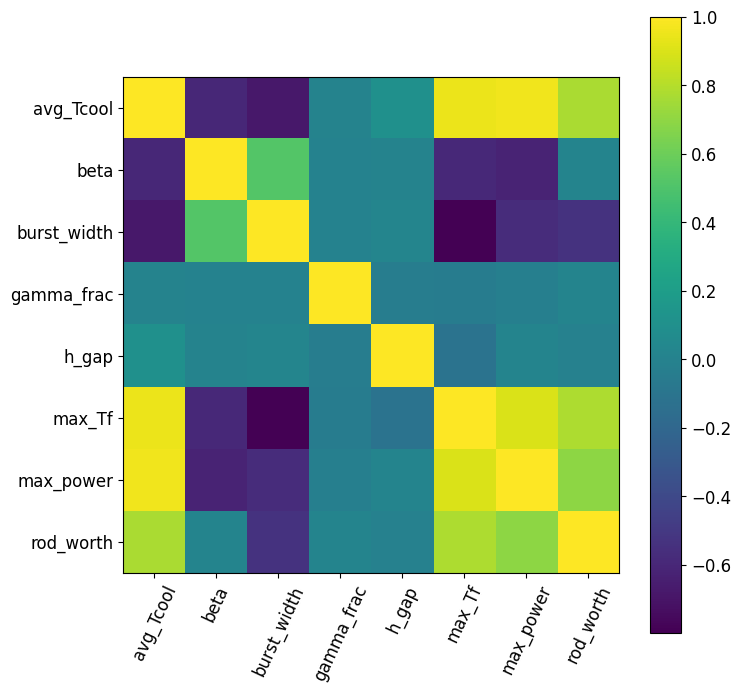

In [5]:
correlation_matrix(data)
plt.show()

A positive correlation exists between average coolant temperature and max fuel temperature, max power, and rod worth. The delayed neutron fraction and burst width negatively correlate with max fuel temperature, max power, and rod worth.

We train/test split into 70%/30% and scale inputs and outputs using min-max scaling to optimize model training.

In [6]:
xtrain, xtest, ytrain, ytest = train_test_split(data=[inputs, outputs], test_size=0.3)
xtrain, xtest, xscaler = scale_data(xtrain, xtest, scaler=MinMaxScaler())
ytrain, ytest, yscaler = scale_data(ytrain, ytest, scaler=MinMaxScaler())

## Model Initialization

We will examine the performance of 6 regression models in this data set:

- linear: `Linear`,
- lasso: `Lasso`,
- decision tree: `DT`,
- random forest: `RF`,
- k-nearest neighbors regression: `KN`,
- dense feedforward neural network: `FNN`.

For hyperparameter tuning, we initialize all classical models as scikit-learn defaults. For the FNN, we define input and output layers with possible dropout layers. These layers include hyperparameter tuning of their number of nodes, the use of sublayers, and the dropout rate. The dense hidden layers include tuning of their depth.

In [7]:
model_settings = {
    "models": ["Linear", "Lasso", "DT", "RF", "KN", "FNN"],
    "FNN": {
        "structural_params": {
            "Dense_hidden": {
                "num_layers": mai.Int(min_value=0, max_value=3),
                "units": mai.Int(min_value=25, max_value=400),
                "activation": "relu",
                "kernel_initializer": "normal",
                "sublayer": mai.Choice(["Dropout_hidden", "None"]),
                "Dropout_hidden": {
                    "rate": mai.Float(min_value=0.4, max_value=0.6),
                },
            },
            "Dense_output": {
                "units": ytrain.shape[-1],
                "activation": "linear",
                "kernel_initializer": "normal",
            },
        },
        "optimizer": "Adam",
        "Adam": {
            "learning_rate": mai.Float(min_value=1e-5, max_value=0.001),
        },
        "compile_params": {
            "loss": "mean_absolute_error",
            "metrics": ["mean_absolute_error"],
        },
        "fitting_params": {
            "batch_size": mai.Choice([8, 16, 32]),
            "epochs": 50,
            "validation_split": 0.15,
        },
    },
}
tuner = mai.Tuner(xtrain, ytrain, model_settings=model_settings)

## Hyperparameter Tuning

We use a random search with 200 iterations and five cross-validation splits (1000 fits per model) for the classical models. The hyperparameter search space is defined for all but linear regression in which the default scikit-learn configuration will be tested. For the FNN, we use a Bayesian search with 50 iterations and five cross-validation splits (250 fits total). This offers possible convergence on an optimal configuration without taking excessive time. Classical models tend to be simpler than neural networks, so many random search iterations are possible.

In [8]:
random_search_spaces = {
    "Lasso": {
        "alpha": uniform(loc=0.0001, scale=0.0099), # 0.0001 - 0.01
    },
    "DT": {
        "max_depth": randint(low=5, high=50), # 5 - 50
        "max_features": [None, "sqrt", "log2", 2, 4, 6],
        "min_samples_split": randint(low=2, high=20), # 2 - 20
        "min_samples_leaf": randint(low=1, high=20), # 1 - 20
    },
    "RF": {
        "n_estimators": randint(low=50, high=200), # 50 - 200
        "criterion": ["squared_error", "absolute_error", "poisson"],
        "min_samples_split": randint(low=2, high=20), # 2 - 20
        "min_samples_leaf": randint(low=1, high=20), # 1 - 20
        "max_features": [None, "sqrt", "log2", 2, 4, 6],
    },
    "KN": {
        "n_neighbors": randint(low=1, high=20), # 1 - 20
        "weights": ["uniform", "distance"],
        "leaf_size": randint(low=1, high=30), # 1 - 30
        "p": randint(low=1, high=10), # 1 - 10
    },
}
start = time.time()
random_search_configs = tuner.random_search(
    param_spaces=random_search_spaces, 
    n_iter=200,
    n_jobs=6,
    cv=5,
)
bayesian_search_configs = tuner.nn_bayesian_search(
    objective="r2_score",
    max_trials=50,
    cv=5,
)
print("Hyperparameter tuning took " + str((time.time() - start) / 60) + " minutes to process.")

Hyperparameter tuning took 43.74738088051478 minutes to process.


Here is the convergence plot of the Bayesian search:

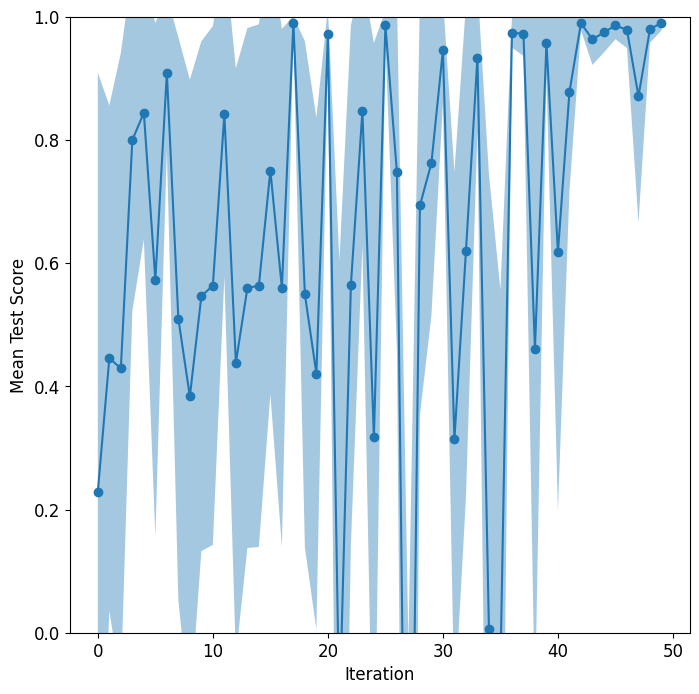

In [9]:
ax = tuner.convergence_plot(model_types="FNN")
ax.set_ylim([0, 1])
plt.show()

## Post-processing

We can now pass these parameter configurations to the `pyMAISE.PostProcessor` for model evaluation. We increase the neural network epochs to 200 to improve their fit.

In [10]:
postprocessor = mai.PostProcessor(
    data=(xtrain, xtest, ytrain, ytest), 
    model_configs=[random_search_configs, bayesian_search_configs], 
    new_model_settings={
        "FNN": {"fitting_params": {"epochs": 200}},
    },
    yscaler=yscaler,
)

To compare the performance of these models, we compute five metrics for both the training and testing data: 

- mean absolute percentage error: `MAPE` $=\frac{100}{n} \sum_{i = 1}^n \frac{|y_i - \hat{y}_i|}{\text{max}(\epsilon, |y_i|)}$,
- root mean squared error `RMSE` $=\sqrt{\frac{1}{n}\sum^n_{i = 1}(y_i - \hat{y}_i)^2}$,
- root mean squared percentage error `RMSPE` $= \sqrt{\frac{1}{n}\sum_{i = 1}^n\Big(\frac{y_i - \hat{y}_i}{\text{max}(\epsilon, |y_i|)}\Big)^2}$,
- mean absolute error `MAE` = $=\frac{1}{n}\sum^n_{i = 1}|y_i - \hat{y}_i|$,
- and r-squared `R2` $=1 - \frac{\sum^n_{i = 1}(y_i - \hat{y}_i)^2}{\sum^n_{i = 1}(y_i - \bar{y}_i)^2}$,

where $y$ is the actual outcome, $\bar{y}$ is the average outcome, $\hat{y}$ is the model predicted outcome, and $n$ is the number of observations. The averaged performance metrics are shown below.

In [11]:
postprocessor.metrics(y="max_power").drop("Parameter Configurations", axis=1)

,Model Types,Train R2,Train MAE,Train MAPE,Train RMSE,Train RMSPE,Test R2,Test MAE,Test MAPE,Test RMSE,Test RMSPE
24,FNN,0.999852,1.699854,1.256283,2.468033,4.722631,0.999826,1.835816,1.458129,2.916537,5.567953
21,FNN,0.999918,1.127129,0.796116,1.833239,1.552226,0.999801,1.365720,0.861927,3.126094,1.616800
25,FNN,0.999672,3.138061,2.933183,3.676620,4.800341,0.999609,3.292828,3.106852,4.377233,5.097466
22,FNN,0.999237,4.904743,3.195386,5.608668,4.712873,0.999250,5.007710,3.405431,6.061238,5.493813
23,FNN,0.998411,5.961130,2.895374,8.091014,5.092613,0.998364,6.257894,3.002727,8.952768,5.261215
11,RF,0.996629,5.304325,2.319889,11.785955,3.832069,0.991116,11.428480,4.791165,20.865264,6.736489
12,RF,0.996067,5.766477,2.480829,12.729718,4.087183,0.990400,11.645784,4.777181,21.690159,6.706852
14,RF,0.994627,7.015301,3.009012,14.880166,4.906394,0.989131,12.360400,5.004573,23.079143,6.963417
13,RF,0.995233,6.186133,2.708629,14.015775,4.417449,0.988940,11.386044,4.662103,23.281506,6.891529
15,RF,0.994476,6.441467,2.785306,15.086559,4.779654,0.988741,11.919416,4.847624,23.490204,6.882004


For max power, all but linear and lasso regression have tested $R^2$ greater than 0.95. The FNN and random forest models performed exceptionally with test $R^2$ greater than 0.99.

In [12]:
postprocessor.metrics(y="burst_width").drop("Parameter Configurations", axis=1)

,Model Types,Train R2,Train MAE,Train MAPE,Train RMSE,Train RMSPE,Test R2,Test MAE,Test MAPE,Test RMSE,Test RMSPE
25,FNN,0.993917,0.004330,1.108645,0.009463,1.745603,0.989397,0.005266,1.325654,0.014530,3.550121
24,FNN,0.995823,0.003956,1.080418,0.007841,1.715023,0.989178,0.004937,1.273542,0.014679,3.780443
21,FNN,0.993285,0.006719,2.169849,0.009942,2.688709,0.985970,0.007982,2.412915,0.016714,4.452748
22,FNN,0.993884,0.004217,1.124124,0.009488,1.816849,0.983470,0.005470,1.344439,0.018142,4.199390
11,RF,0.979174,0.004123,0.984087,0.017509,1.810321,0.970323,0.007950,1.806846,0.024309,3.983300
15,RF,0.966754,0.005200,1.202897,0.022121,2.366208,0.968834,0.008271,1.839297,0.024911,3.941832
23,FNN,0.968362,0.007532,1.726643,0.021580,3.430110,0.964017,0.009178,1.996662,0.026767,4.399339
14,RF,0.973912,0.005283,1.262896,0.019596,2.363813,0.964002,0.008324,1.839627,0.026773,3.955729
12,RF,0.978590,0.004373,1.051177,0.017752,1.959277,0.963183,0.008101,1.821587,0.027076,4.222441
13,RF,0.980769,0.004929,1.183498,0.016825,2.269449,0.959128,0.008283,1.814489,0.028528,4.034780


For burst width k-nearest neighbors, decision tree, lasso, and linear regression largely struggled. K-nearest neighbors are overfit. The top performers were the FNN and random forest models; however, the FNN was more consistent between training and testing.

In [13]:
postprocessor.metrics(y="max_Tf").drop("Parameter Configurations", axis=1)

,Model Types,Train R2,Train MAE,Train MAPE,Train RMSE,Train RMSPE,Test R2,Test MAE,Test MAPE,Test RMSE,Test RMSPE
25,FNN,0.999532,0.545938,0.059499,0.754793,0.082855,0.999426,0.606922,0.066115,0.896838,0.099307
24,FNN,0.999385,0.644342,0.070049,0.865333,0.096562,0.999283,0.680491,0.074382,1.001813,0.114124
21,FNN,0.999292,0.739538,0.080567,0.928501,0.103014,0.999018,0.827692,0.090418,1.172481,0.131682
22,FNN,0.998933,0.985210,0.106235,1.139831,0.122799,0.998745,1.058086,0.114233,1.325851,0.144121
23,FNN,0.998107,0.963719,0.106022,1.518266,0.174202,0.997697,1.064322,0.117188,1.796139,0.204868
11,RF,0.994683,1.523018,0.164220,2.544729,0.275500,0.988703,2.763608,0.298509,3.977785,0.429070
12,RF,0.993695,1.696249,0.182596,2.771042,0.298416,0.987736,2.843847,0.307049,4.144432,0.448508
15,RF,0.991260,1.993675,0.214964,3.262472,0.353055,0.985931,3.004872,0.324483,4.438993,0.476232
14,RF,0.990509,2.240935,0.241357,3.399858,0.366108,0.985137,3.188399,0.344184,4.562532,0.493237
13,RF,0.990368,2.295046,0.247355,3.425057,0.366766,0.983783,3.247793,0.350634,4.765852,0.513841


Max fuel temperature is a more linear label, with all models performing well with $R^2$ greater than 0.95. Once again, the FNN and random forest models were the top-performing models.

In [14]:
postprocessor.metrics(y="avg_Tcool").drop("Parameter Configurations", axis=1)

,Model Types,Train R2,Train MAE,Train MAPE,Train RMSE,Train RMSPE,Test R2,Test MAE,Test MAPE,Test RMSE,Test RMSPE
24,FNN,0.999877,0.006093,0.001085,0.008180,0.001456,0.999890,0.005894,0.001050,0.008247,0.001468
25,FNN,0.999911,0.004936,0.000879,0.006966,0.001240,0.999878,0.005646,0.001006,0.008693,0.001547
21,FNN,0.999715,0.011354,0.002024,0.012467,0.002223,0.999724,0.011706,0.002087,0.013044,0.002325
23,FNN,0.999554,0.012537,0.002234,0.015601,0.002778,0.999495,0.013301,0.002370,0.017658,0.003142
22,FNN,0.998758,0.024142,0.004301,0.026039,0.004637,0.998844,0.024489,0.004363,0.026710,0.004756
11,RF,0.996797,0.025205,0.004489,0.041825,0.007442,0.990428,0.051421,0.009158,0.076863,0.013681
12,RF,0.996255,0.027642,0.004923,0.045223,0.008047,0.990037,0.052449,0.009341,0.078417,0.013957
15,RF,0.994865,0.031991,0.005698,0.052956,0.009424,0.988644,0.054895,0.009776,0.083719,0.014900
14,RF,0.994204,0.035662,0.006352,0.056263,0.010012,0.987811,0.058346,0.010391,0.086737,0.015438
13,RF,0.994462,0.035716,0.006361,0.054994,0.009787,0.986936,0.059233,0.010549,0.089797,0.015982


Average coolant temperature was also well predicted by all models.

In [15]:
postprocessor.metrics().drop(
    ["Parameter Configurations", "Train MAE", "Test MAE", "Train RMSE", "Test RMSE"], 
    axis=1,
)

,Model Types,Train R2,Train MAPE,Train RMSPE,Test R2,Test MAPE,Test RMSPE
25,FNN,0.998258,1.025552,1.657510,0.997077,1.124907,2.187110
24,FNN,0.998735,0.601959,1.633918,0.997045,0.701776,2.365997
21,FNN,0.998053,0.762139,1.086543,0.996128,0.841837,1.550889
22,FNN,0.997703,1.107512,1.664289,0.995077,1.217116,2.460520
23,FNN,0.991109,1.182568,2.174926,0.989893,1.279736,2.467141
11,RF,0.991821,0.868171,1.481333,0.985142,1.726420,2.790635
15,RF,0.986839,1.052216,1.877085,0.983037,1.755295,2.828742
12,RF,0.991152,0.929881,1.588231,0.982839,1.728789,2.847940
14,RF,0.988313,1.129904,1.911582,0.981520,1.799693,2.856955
13,RF,0.990208,1.036461,1.765863,0.979697,1.709444,2.864033


Overall, the top-performing models are the FNNs, some of which are above 0.99 $R^2$ for training and testing data sets. Linear and lasso regression were the worst-performing models.

Below are the hyperparameter configurations of each of the top-performing models.

In [16]:
for model in ["Lasso", "DT", "RF", "KN", "FNN"]:
    postprocessor.print_model(model_type=model)
    print()

Model Type: Lasso
  alpha: 0.00020315144347484598

Model Type: DT
  max_depth: 26
  max_features: None
  min_samples_leaf: 2
  min_samples_split: 4

Model Type: RF
  criterion: squared_error
  max_features: None
  min_samples_leaf: 2
  min_samples_split: 2
  n_estimators: 112

Model Type: KN
  leaf_size: 26
  n_neighbors: 3
  p: 2
  weights: uniform

Model Type: FNN
  Structural Hyperparameters
    Layer: Dense_hidden_0
      units: 326
      sublayer: None
    Layer: Dense_hidden_1
      units: 127
      sublayer: None
    Layer: Dense_output_0
  Compile/Fitting Hyperparameters
    Adam_learning_rate: 0.0009444837105276597
    batch_size: 8
Model: "FNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense_hidden_0 (Dense)      (None, 326)               1630      
                                                                 
 Dense_hidden_1 (Dense)      (None, 127)               41529     
       

Below is the network plot for the FNN.

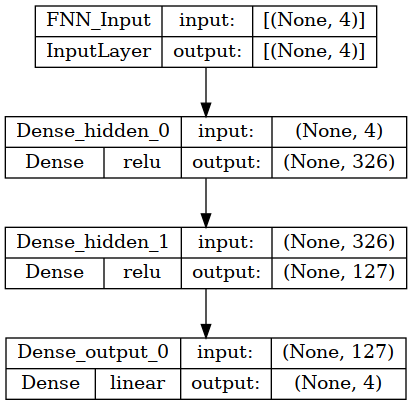

In [17]:
postprocessor.nn_network_plot(
    to_file="./supporting/rod_ejection_network.png",
    show_shapes=True,
    show_layer_names=True,
    expand_nested=True,
    show_layer_activations=True,
)

We can visualize the performance of each model with diagonal validation plots. These plots show the predicted output to the actual production. The performance of FNN is apparent with the spread close around $y= x$. Random forest, k-nearest neighbors, and decision tree performed relatively well on all outputs. Burst width is the most difficult to predict for all the models.

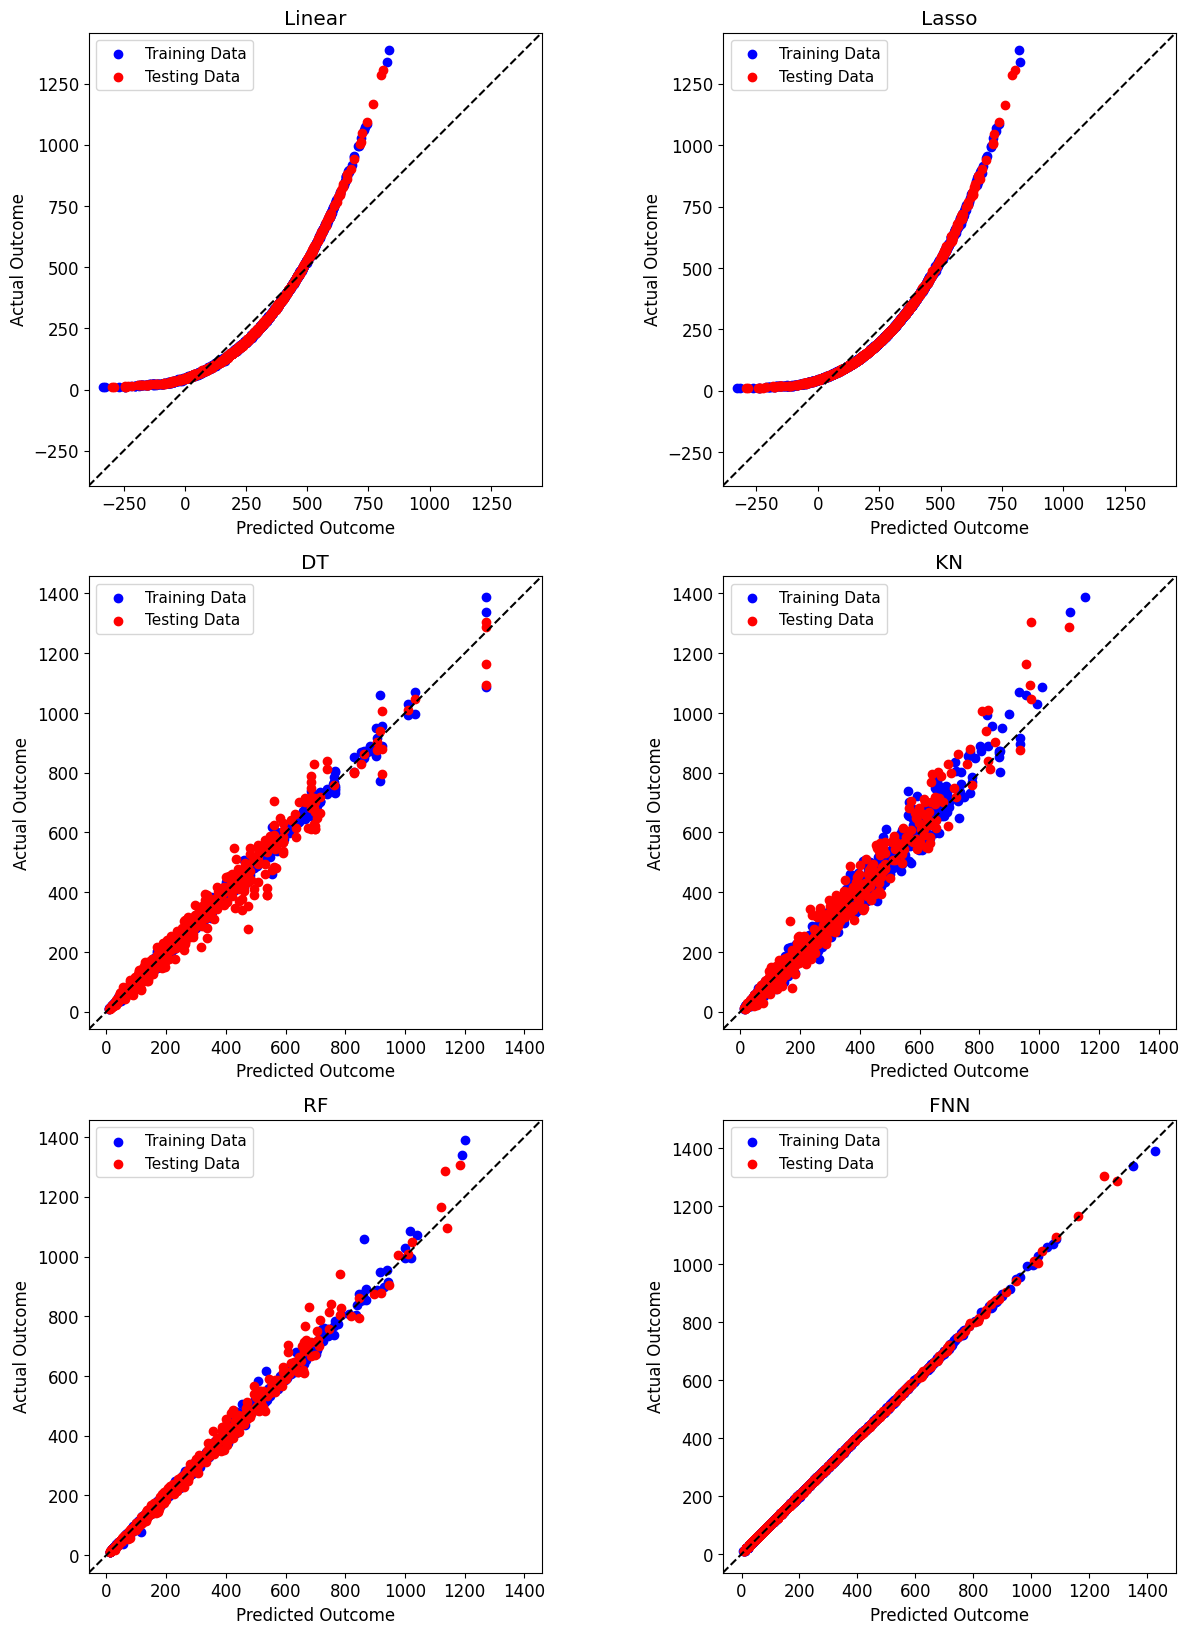

In [18]:
def performance_plot(meth, output):
    models = np.array([["Linear", "Lasso"], ["DT", "KN"], ["RF", "FNN"]])
    fig, axarr = plt.subplots(models.shape[0], models.shape[1], figsize=(15,20))
    for i in range(models.shape[0]):
        for j in range(models.shape[1]):
            plt.sca(axarr[i, j])
            axarr[i, j] = meth(model_type=models[i, j], y=[output])
            axarr[i, j].set_title(models[i, j])


performance_plot(postprocessor.diagonal_validation_plot, "max_power")
plt.show()

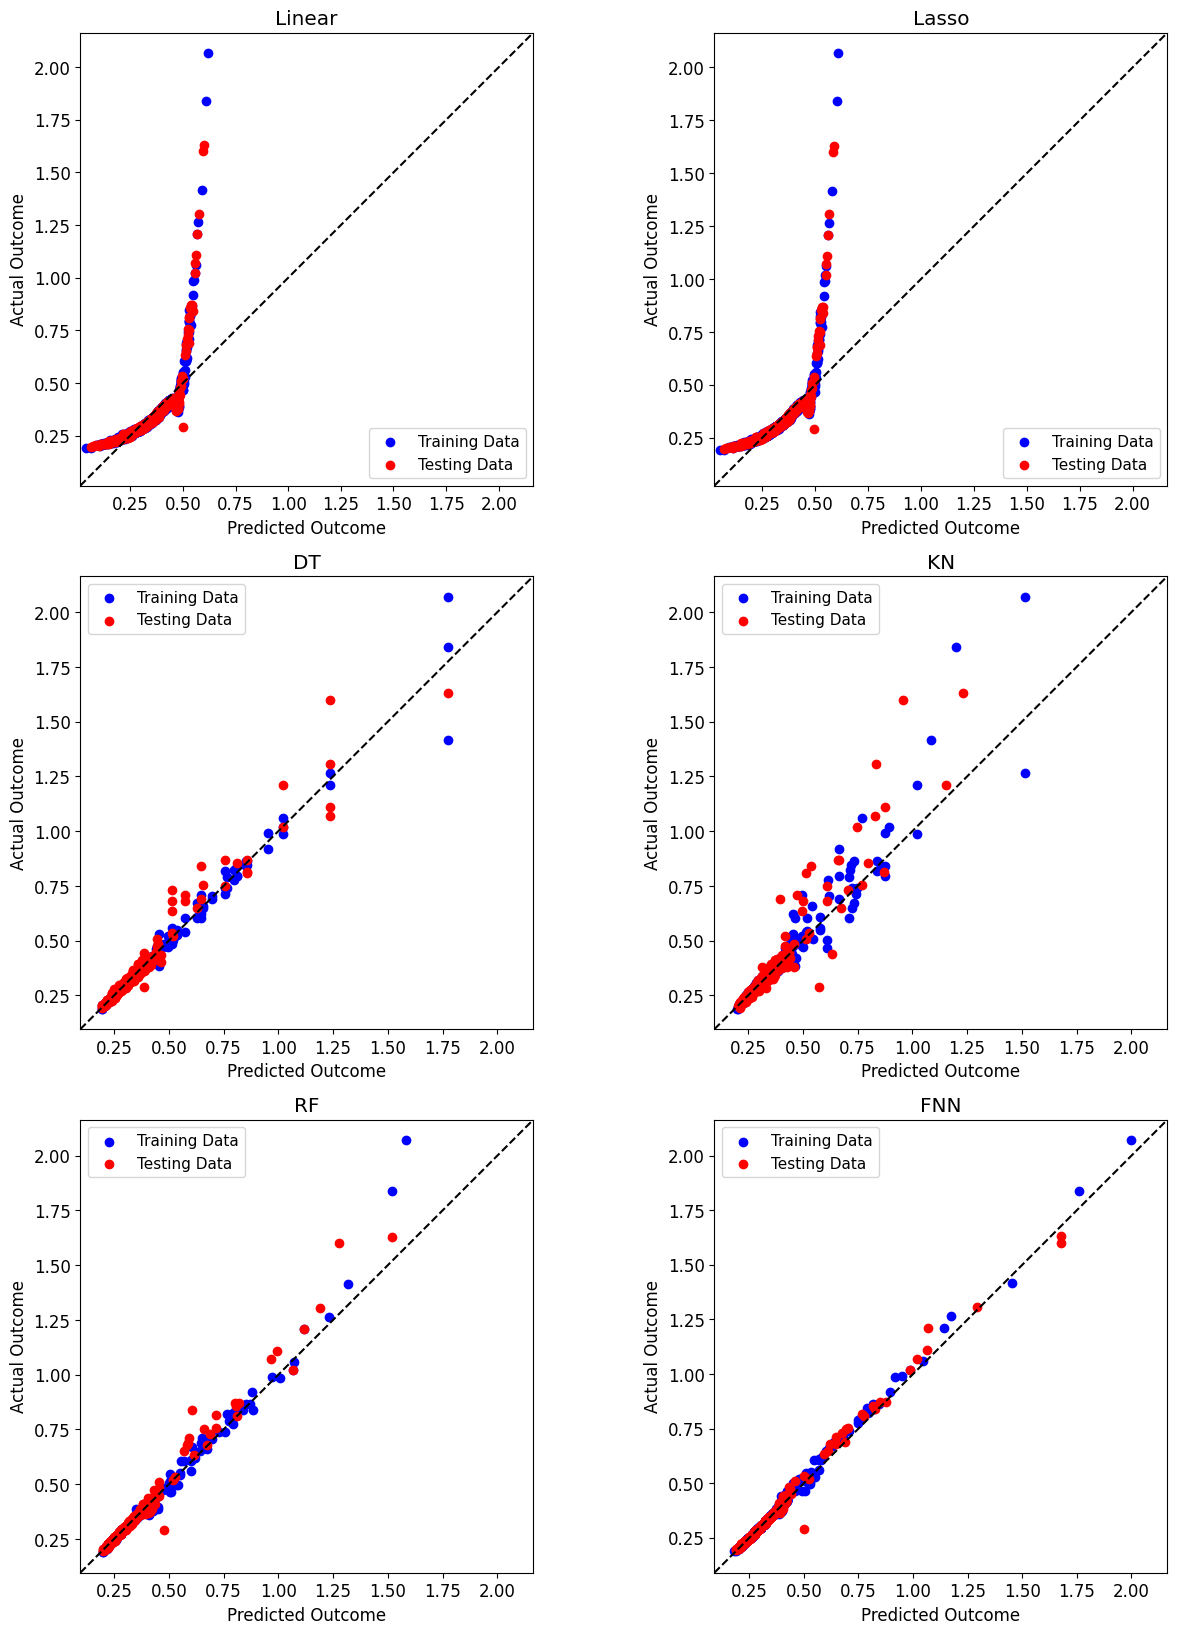

In [19]:
performance_plot(postprocessor.diagonal_validation_plot, "burst_width")
plt.show()

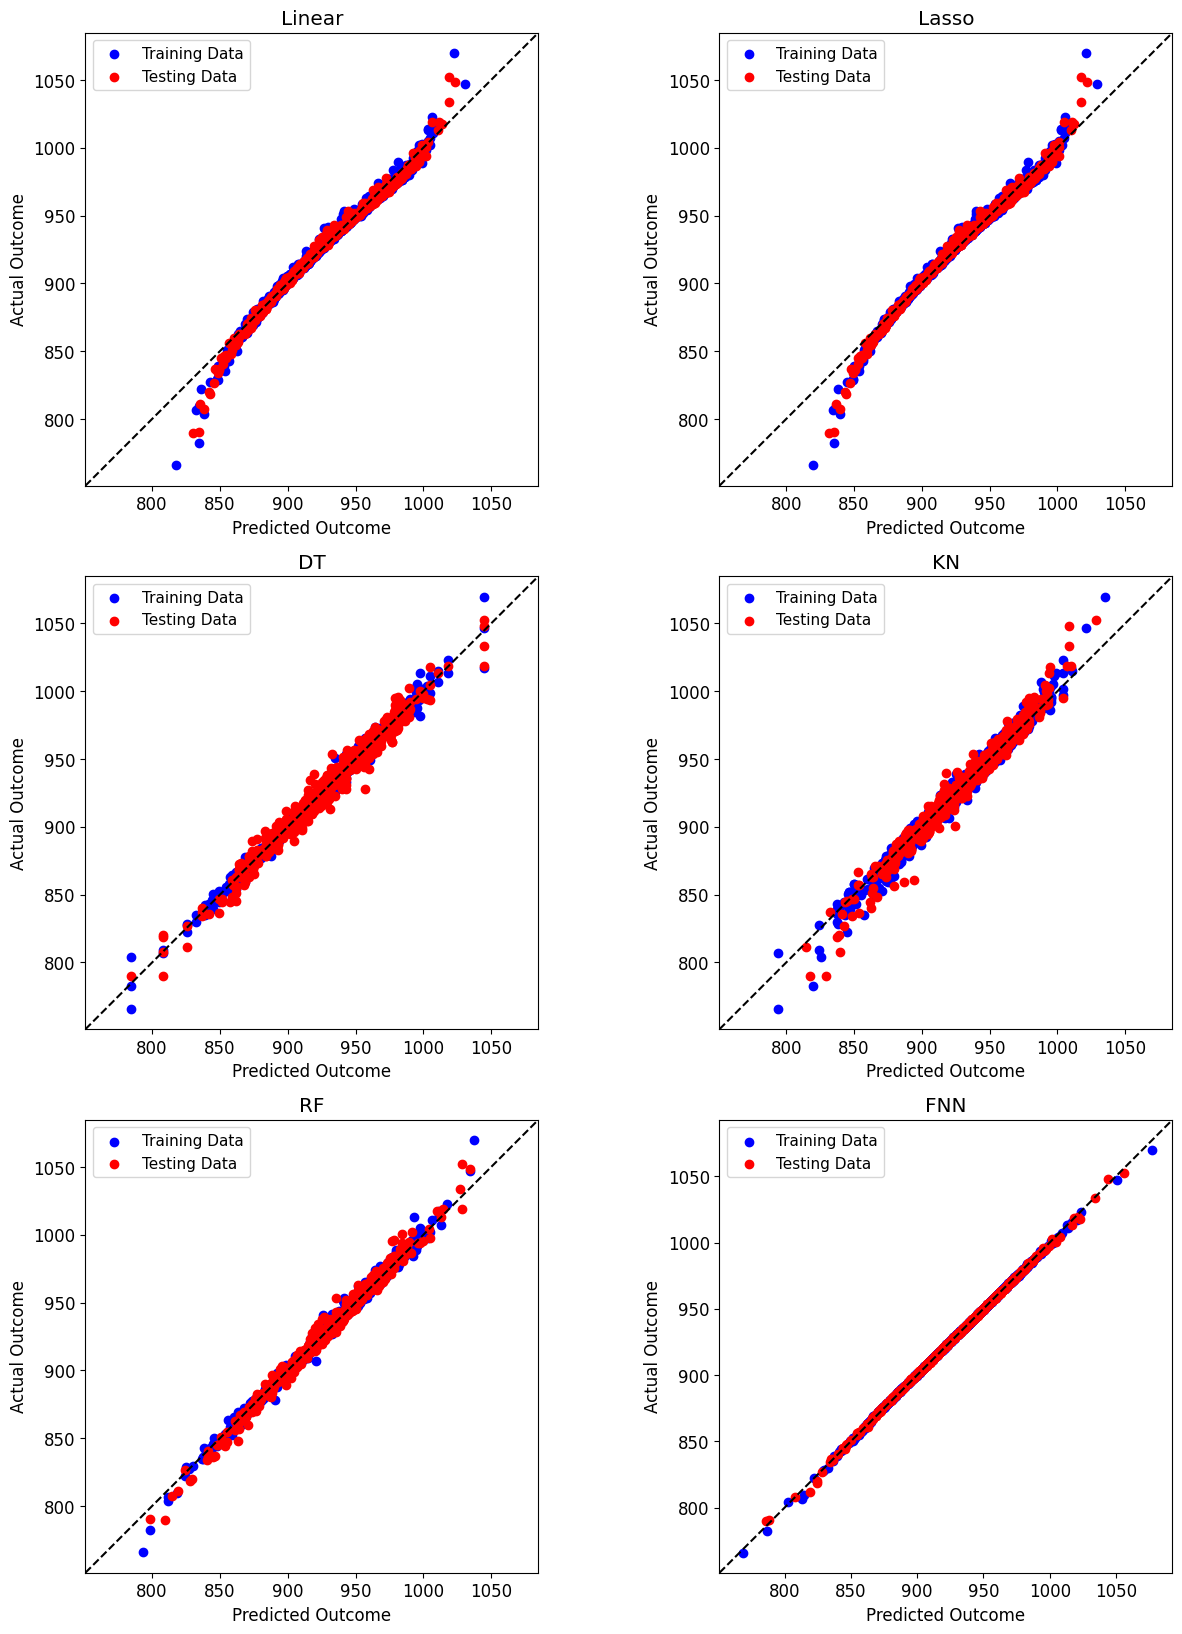

In [20]:
performance_plot(postprocessor.diagonal_validation_plot, "max_Tf")
plt.show()

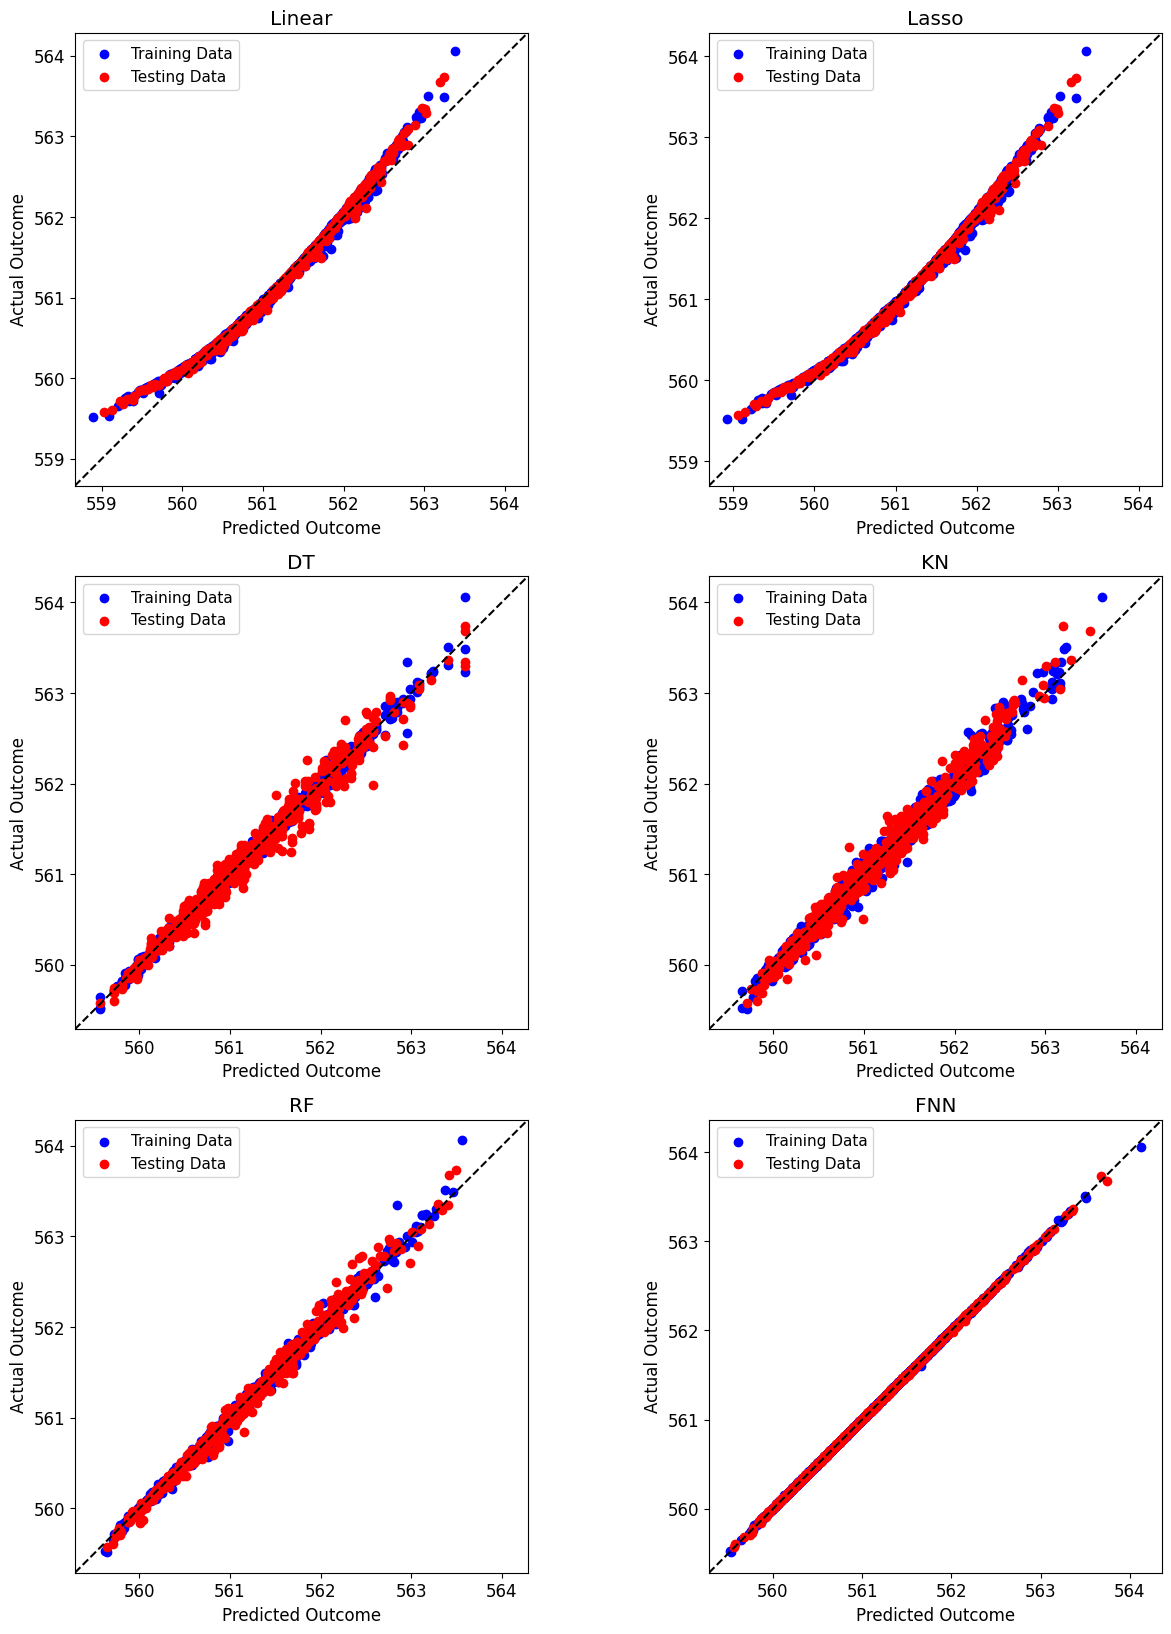

In [21]:
performance_plot(postprocessor.diagonal_validation_plot, "avg_Tcool")
plt.show()

The validation plots for all outputs are given below. Based on the scaling of the $y$-axis, we can see that the FNNs performed the best. Both the diagonal validation and validation plots agree with the performance metrics presented above.

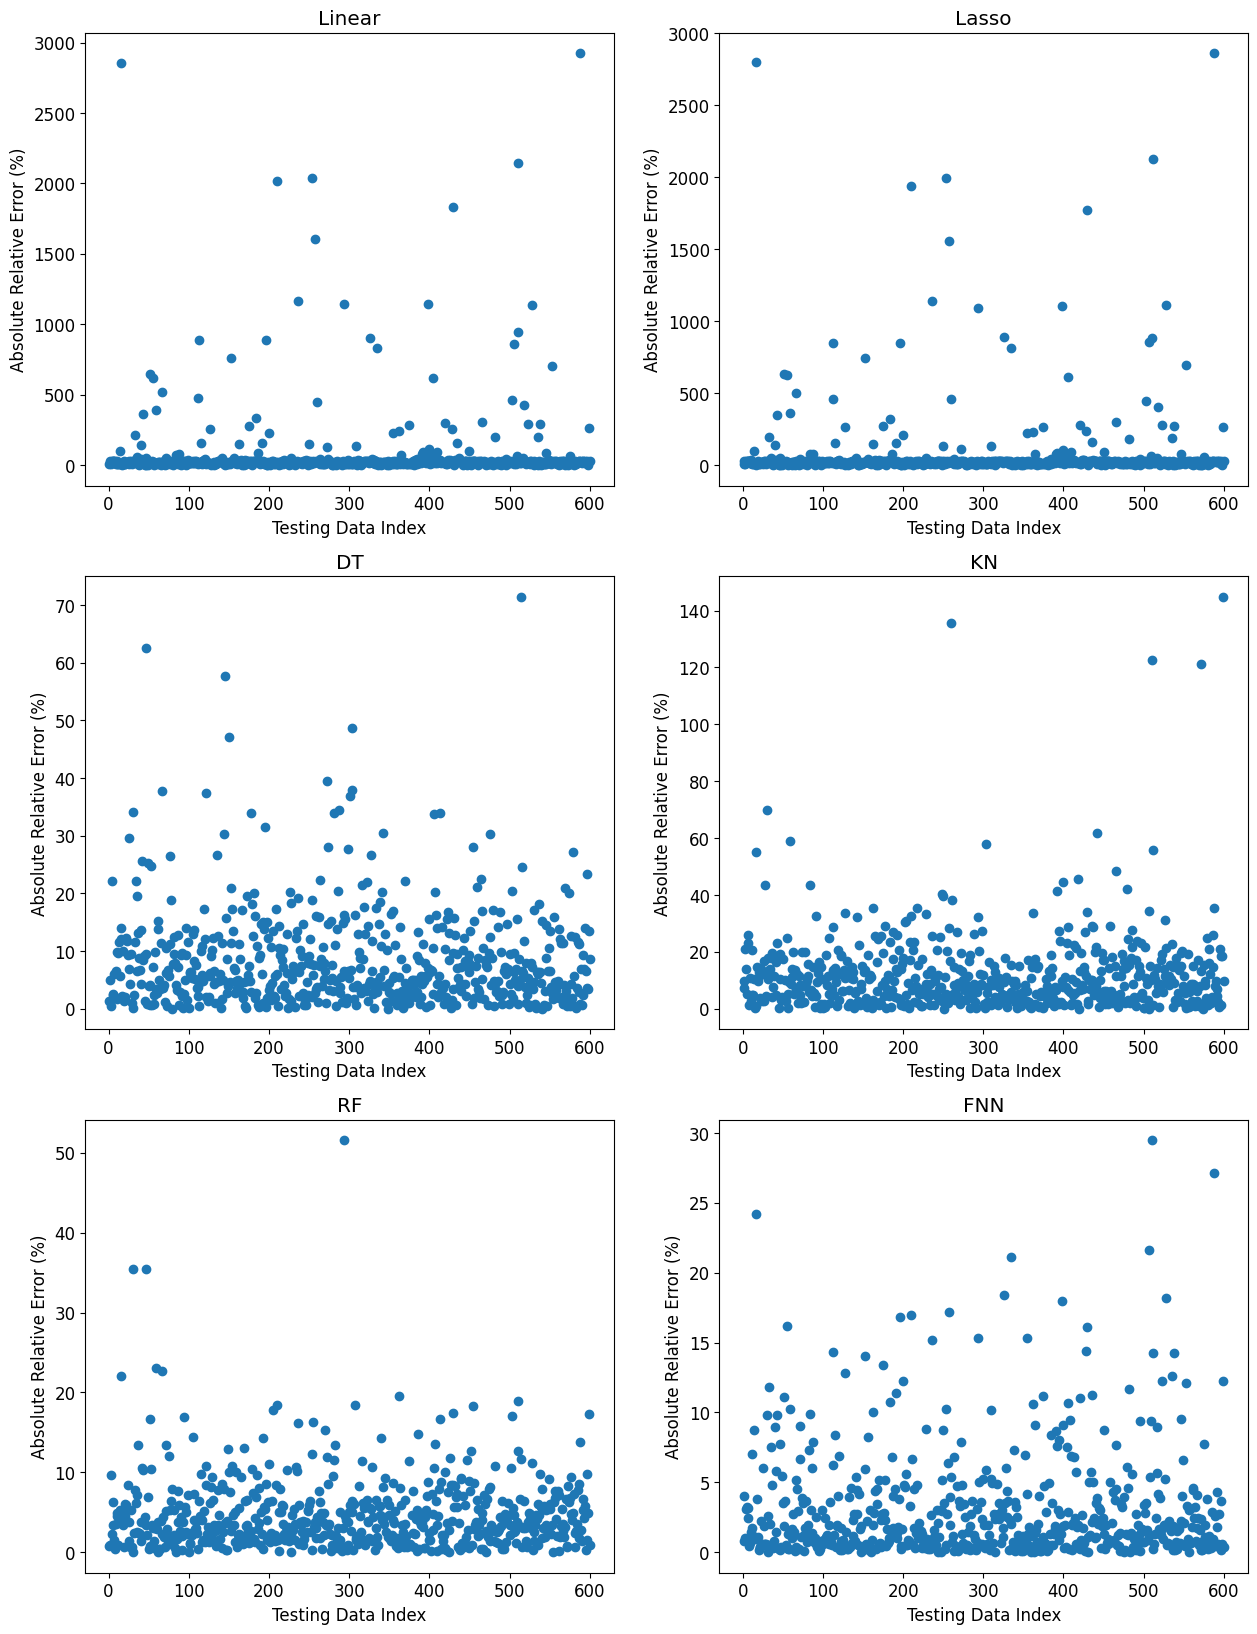

In [22]:
performance_plot(postprocessor.validation_plot, "max_power")
plt.show()

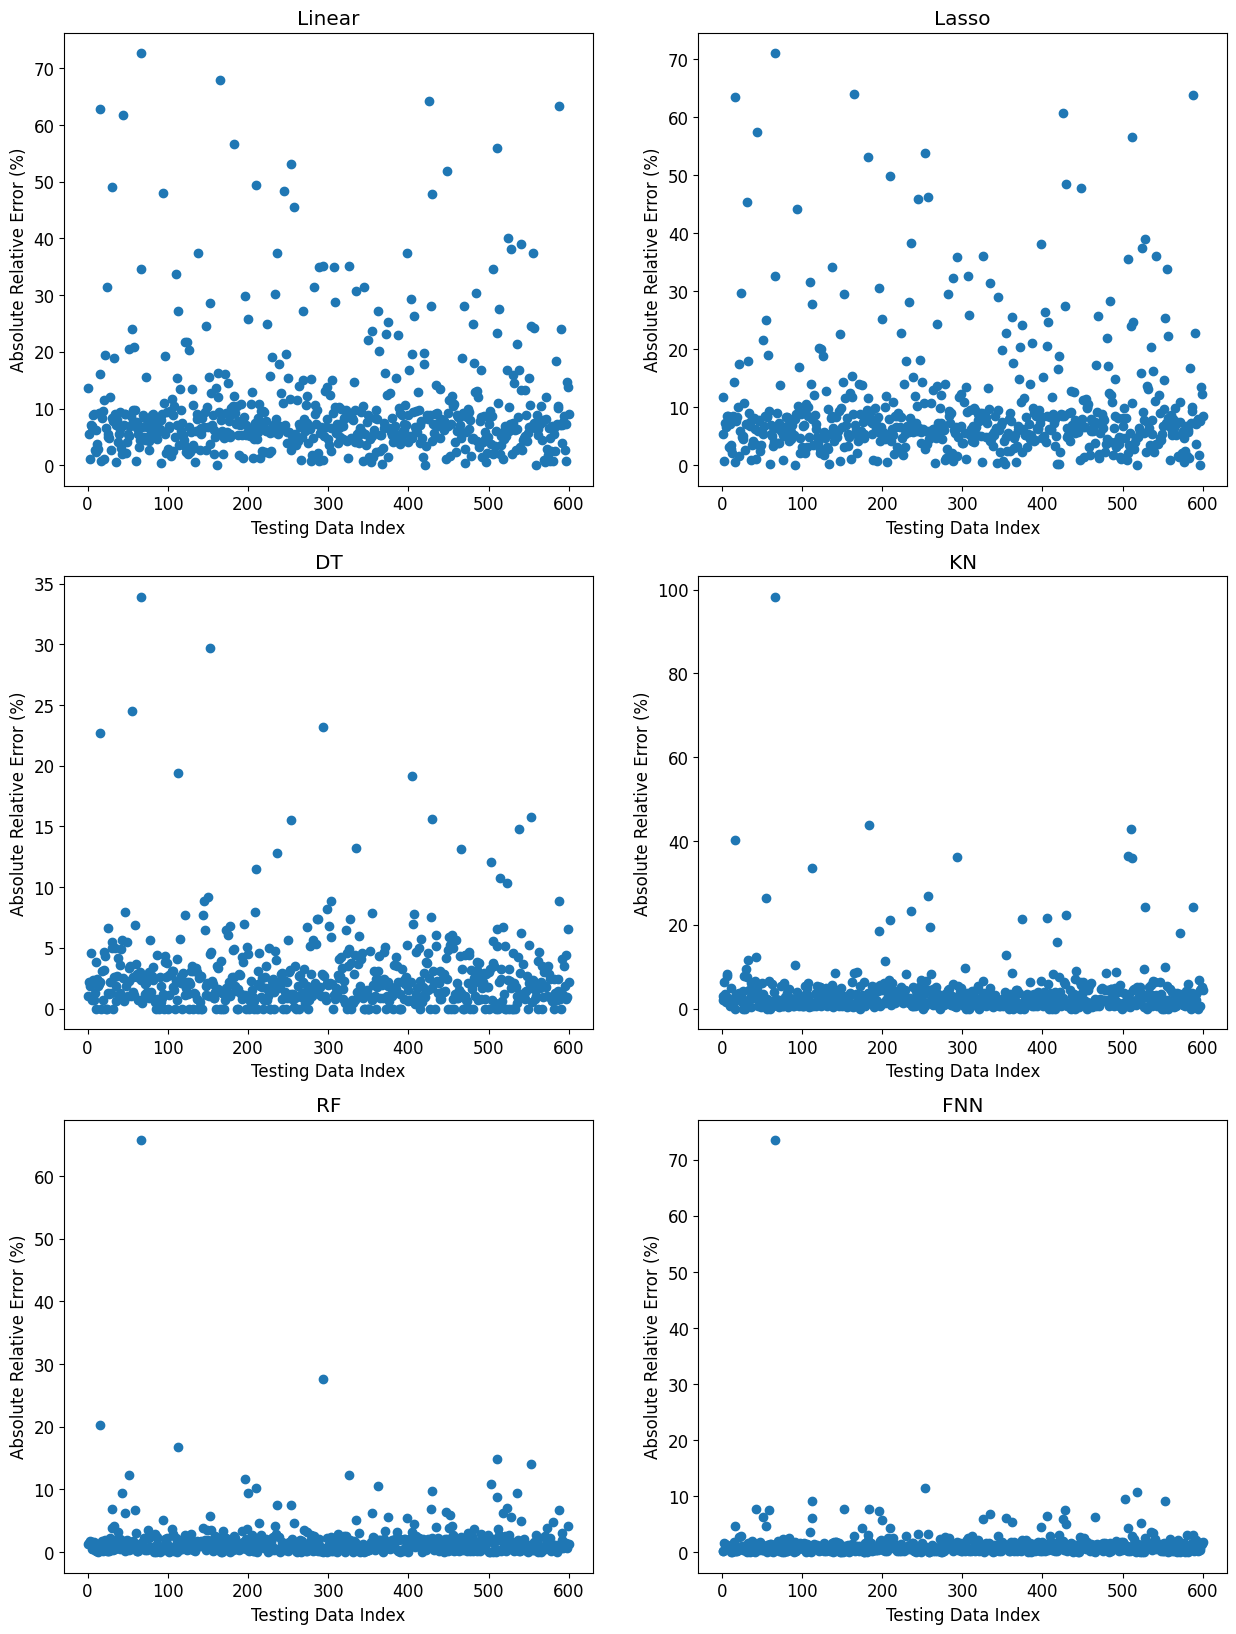

In [23]:
performance_plot(postprocessor.validation_plot, "burst_width")
plt.show()

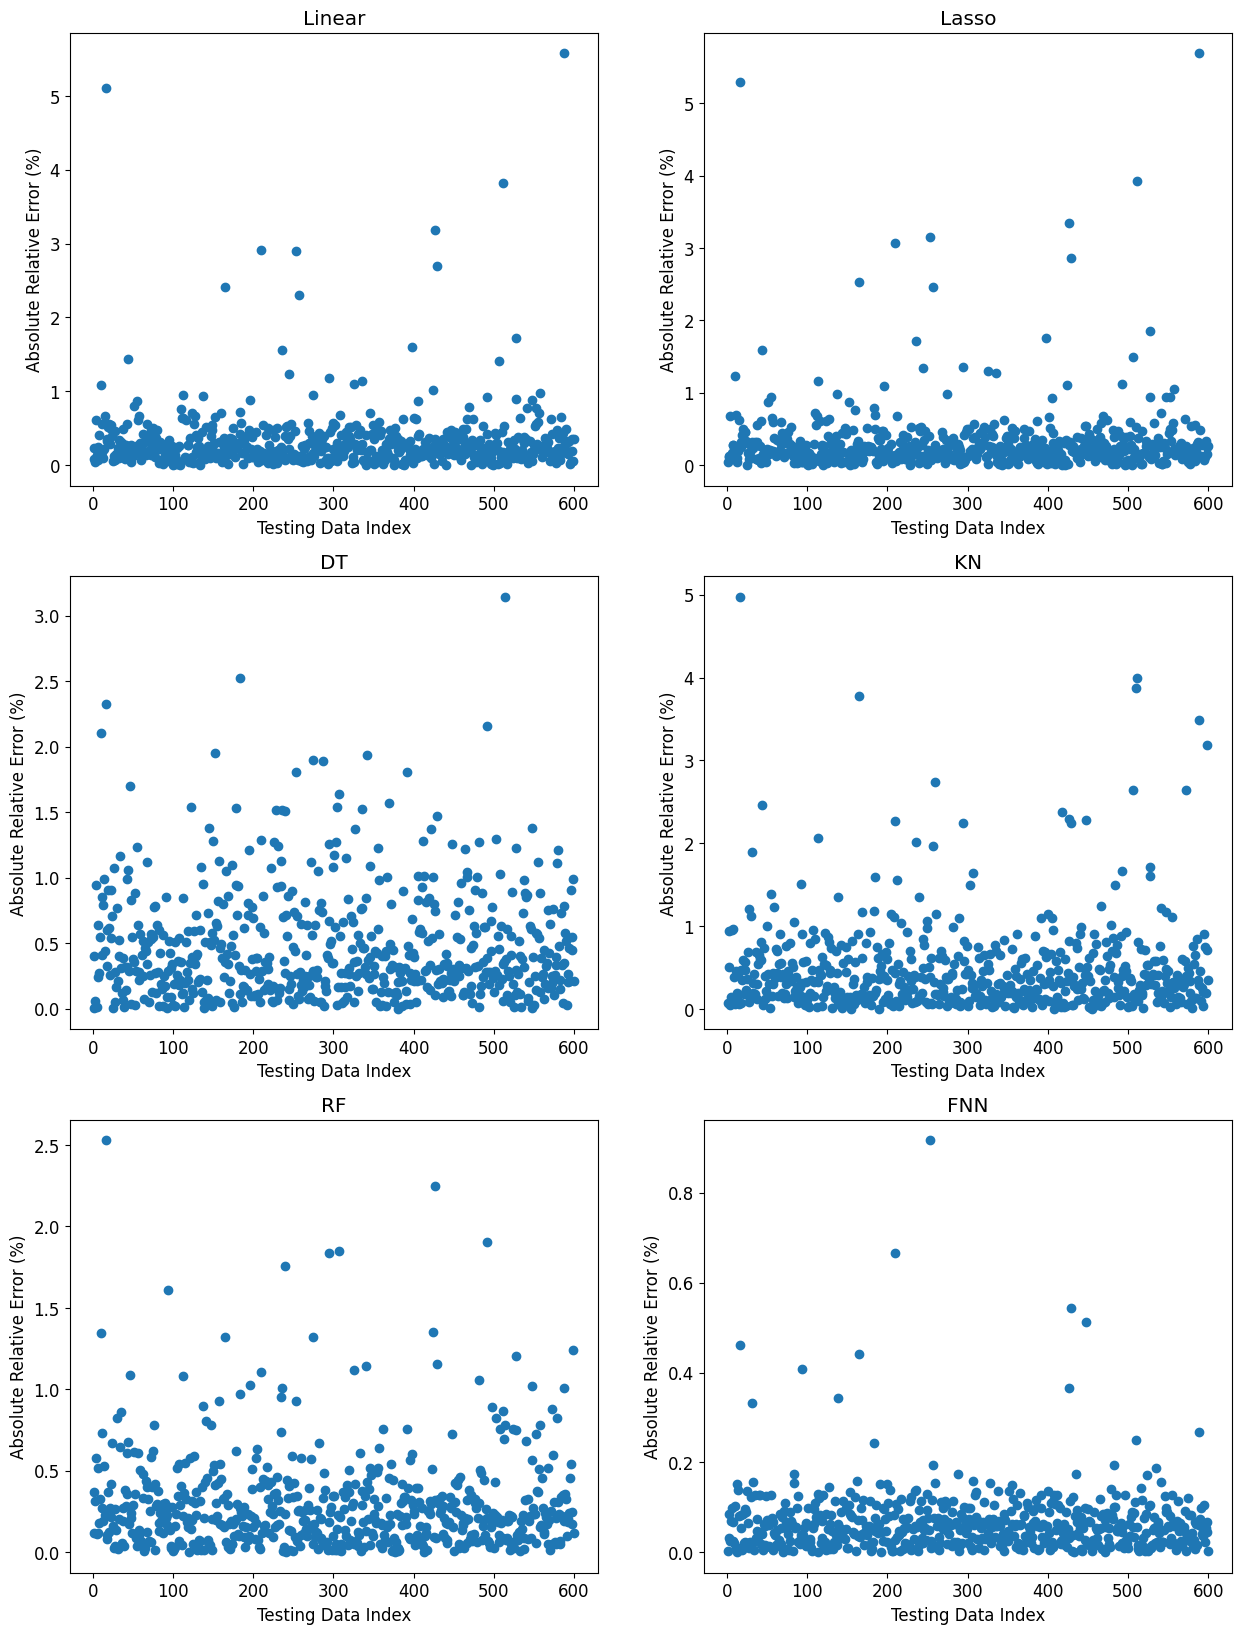

In [24]:
performance_plot(postprocessor.validation_plot, "max_Tf")
plt.show()

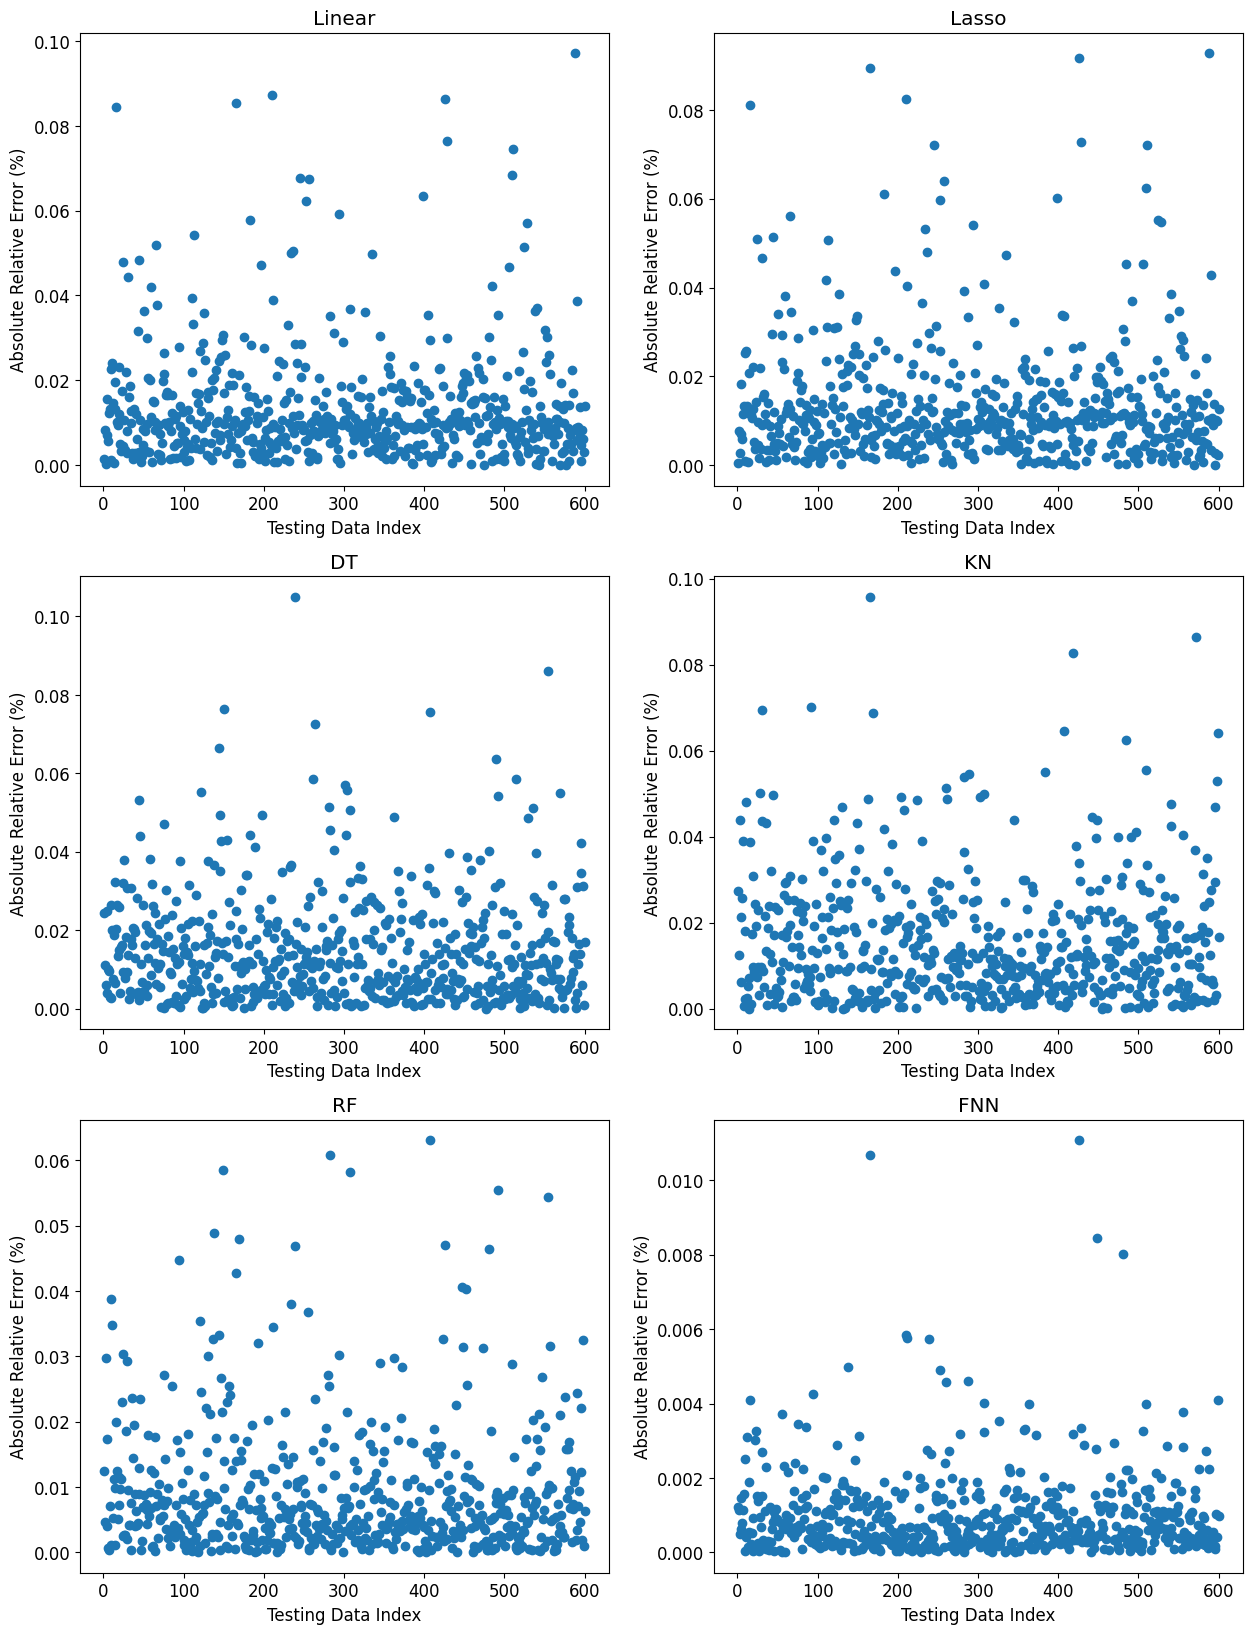

In [25]:
performance_plot(postprocessor.validation_plot, "avg_Tcool")
plt.show()

Finally, the most learning curve for the most performant FNN is shown below. It shows no overfitting, as the validation curve follows the training curve closely.

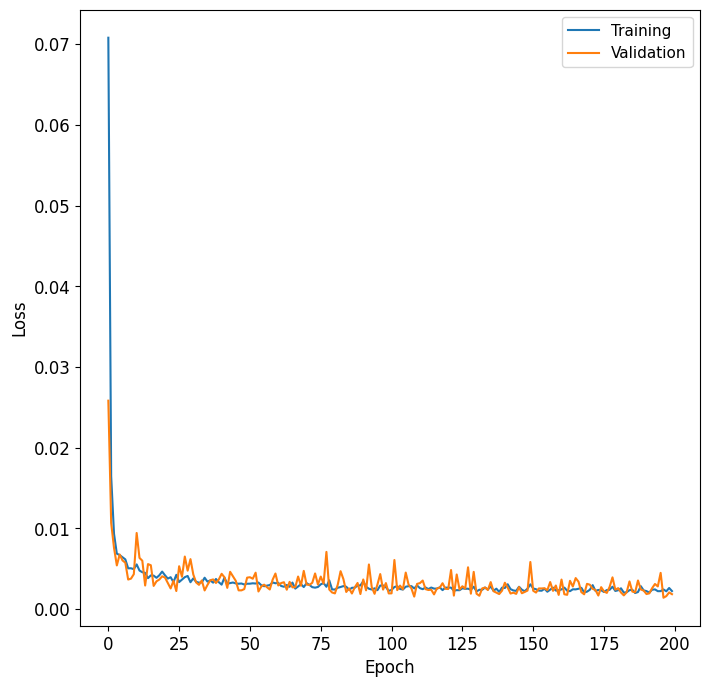

In [26]:
postprocessor.nn_learning_plot()
plt.show()

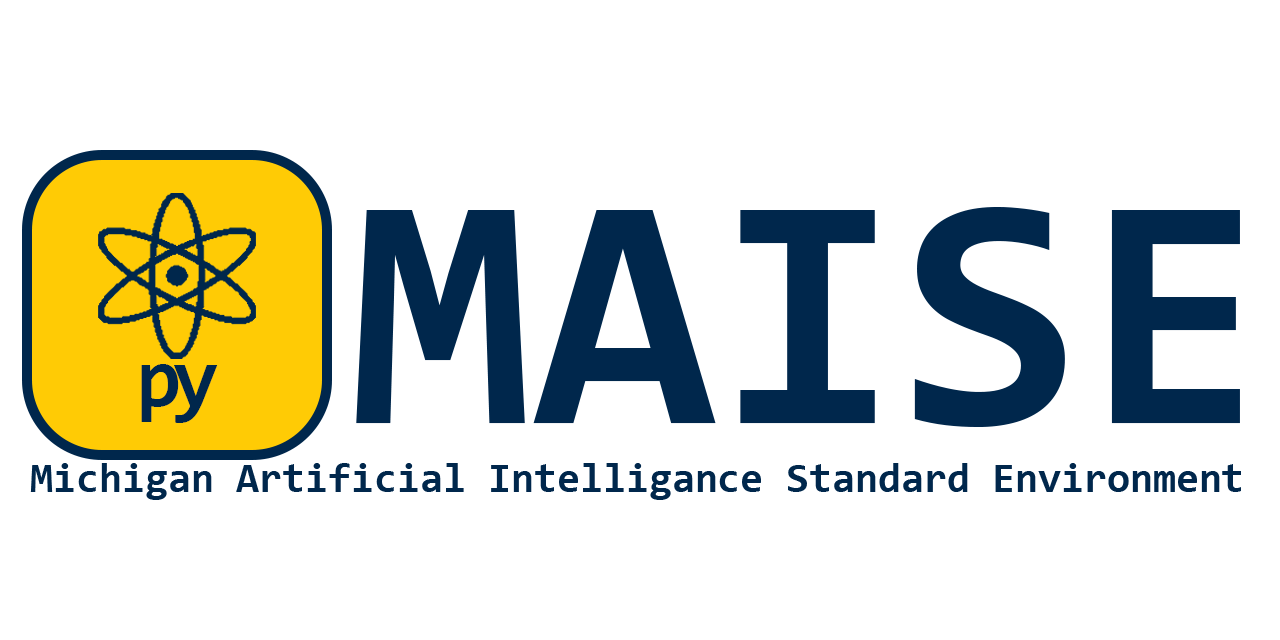